# Option A - Data Challenge: Build a Banking Model - Modelling (3/4)
*Analytics for Financial Services - MBD02*
<br>
*Vilhelm Stiernstedt - 08/06/2018*


#### Section Description
In this section we will conduct all necessary data preparation such as:
1. model preparation
2. models 
3. evaluation

In [284]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# lgb
import lightgbm as lgb

# sklearn libs
from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize, StandardScaler, minmax_scale
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# keras
from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras import metrics

# Warning settings -> suppress depreciation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# plot settings
%matplotlib inline

In [285]:
# import data
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')

# set index - customerID
train.set_index('customerID', inplace=True)
test.set_index('customerID', inplace=True)

In [286]:
# shapes
train.shape, test.shape

((522938, 39), (174313, 38))

In [287]:
list(train)

['age',
 'channel',
 'externalScore',
 'indBadDebt',
 'indBadLocation',
 'indCreditBureau',
 'indInternet',
 'indSimin',
 'indXlist',
 'previous',
 'salary',
 'sex',
 'status',
 'sumExternalDefault',
 'target',
 'salary_ordinal',
 'status_new',
 'salary_ord_shrink',
 'channel_new',
 'age_qbin',
 'sumExternalDefault_arbbin',
 'sumExternalDefault_binarybin',
 'externalScore_arbbin',
 'customerID_class',
 'multi_accoutns',
 'sameID_diff_extScore',
 'numLoans_known',
 'numMortgages_known',
 'status_known',
 'channel_known',
 'salary_known',
 'externalScore_log',
 'externalScore_sqrt',
 'externalScore**2',
 'externalScore**3',
 'sumExternalDefault_log',
 'sumExternalDefault_sqrt',
 'sumExternalDefault**2',
 'sumExternalDefault**3']

##  Data Preparation

In [288]:
# extract target from training set
target = train.target
# drop target from training set
train.drop('target', axis=1, inplace=True)
# One-hot encoding: Create dummies for training data
train_onehot = pd.get_dummies(train)

# Convert to numpy arrays
x = np.array(train_onehot)
y = np.array(target)

# split training data into training and validation data 80/20 split
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.20, random_state=42)

In [289]:
x_train.shape, y_train.shape

((418350, 99), (418350,))

In [290]:
x_test.shape, y_test.shape

((104588, 99), (104588,))

## BaseLine Revisted
Lets start by running the two best models used in baseline to see if null imputation and feature engineering have added information. 

### Linear SVM

In [291]:
from sklearn.svm import LinearSVC

# define model
clf_svm = LinearSVC()

# fit model
clf_svm.fit(x_train, y_train)

# predict
clf_svm_pred = clf_svm.predict(x_test)

In [292]:
# classification report
roc_auc_score(y_test, clf_svm_pred)

0.559100135598014

In [293]:
# Create confusion matrix
pd.DataFrame(confusion_matrix(y_test, clf_svm_pred))

,0,1
0,59950,9059
1,26703,8876


In [294]:
# define LR classifier
clf_lr = LogisticRegressionCV()
clf_lr.fit(x_train, y_train)

# define lgbm classifier
clf_lgbm = lgb.LGBMClassifier()
clf_lgbm.fit(x_train, y_train)

# define rf classifier
clf_rf = RandomForestClassifier()
clf_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### ROC/AUC Evaluation

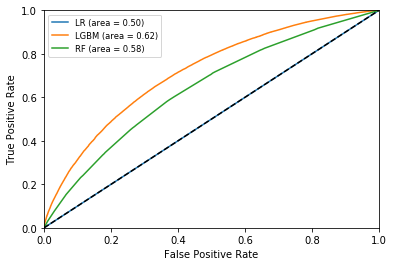

In [295]:
# define list with trained models and labels
models = [clf_lr, clf_lgbm, clf_rf]
labels = ['LR', 'LGBM', 'RF']

# calc roc for each model 
for m, l in zip(models, labels):
    logit_roc_auc = roc_auc_score(y_test, m.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, m.predict_proba(x_test)[:,1])
    plt.plot(fpr, tpr, label='%s (area = %0.2f)' % (l, logit_roc_auc))

# plot settings
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')
plt.show()

#### Conclusion 
- LGBM: same score as before
- LR: worse score, from 60 to 50.
- RF: same score as before
- SVM: 55 inline with previous score
    
#### Notes
Lets try to build model pipelines that can improve the score. Lets try to use feature selection and scalers.

## Feature Importance

In [296]:
# Merge feature names and importance score into df
features_names = pd.DataFrame(train.columns)
feature_importance_score = pd.DataFrame(clf_lgbm.feature_importances_)
lgbm_feature_importance = pd.concat([features_names, feature_importance_score], axis=1)

# Assign columns names
new_cols = ['lgbm_feature', 'lgbm_importance']
lgbm_feature_importance.columns = new_cols

# Sort values by importance and show top 20
lgbm_feature_importance = lgbm_feature_importance.sort_values('lgbm_importance', ascending=False).head(20)
# insert ranking score
lgbm_feature_importance['rank'] = range(1, 21)
# set rank as index
lgbm_feature_importance.set_index('rank', inplace=True)

lgbm_feature_importance

,lgbm_feature,lgbm_importance
rank,,
1,channel,480
2,age,427
3,indXlist,201
4,indInternet,105
5,externalScore**2,97
6,numLoans_known,95
7,status_known,85
8,previous,85
9,externalScore**3,78


## Model Pipelines

### Pipeline 1 - LGBM w. Selector
In this pipeline we will try to use feature selector Kbest to exclude non-significant variables.

In [300]:
# define pipeline
pipeline = Pipeline([('select', SelectKBest()),
                     ('clf', lgb.LGBMClassifier())])

# define parameters
parameters = {'select__k': (25, 50, 75, 99),
              'clf__n_estimators': [25, 50, 100, 150],
              'clf__learning_rate': [0.05],
              'clf__max_depth': [3, 5, 6, 7, 8],
              'clf__num_leaves': [15, 25, 30],
              'clf__feature_fraction': [0.6, 0.8, 0.10],
              'clf__bagging_fraction': [0.10, 0.12, 0.15],
              'clf__bagging_freq': [8, 10, 12],
              'clf__boosting_type': ('gbdt', 'dart')}

# define random search grid with cv
rscv_clf_lgbm = RandomizedSearchCV(estimator=pipeline, verbose=3,
                              param_distributions=parameters,
                              n_jobs=1, n_iter=3, cv=3, 
                              random_state=42)
# fit model
rscv_clf_lgbm.fit(x, y)

# get best score from CV
rscv_clf_lgbm.best_score_

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] select__k=75, clf__num_leaves=30, clf__n_estimators=50, clf__max_depth=5, clf__learning_rate=0.05, clf__feature_fraction=0.6, clf__boosting_type=gbdt, clf__bagging_freq=12, clf__bagging_fraction=0.12 
[CV]  select__k=75, clf__num_leaves=30, clf__n_estimators=50, clf__max_depth=5, clf__learning_rate=0.05, clf__feature_fraction=0.6, clf__boosting_type=gbdt, clf__bagging_freq=12, clf__bagging_fraction=0.12, score=0.6948093670043715, total=   5.5s
[CV] select__k=75, clf__num_leaves=30, clf__n_estimators=50, clf__max_depth=5, clf__learning_rate=0.05, clf__feature_fraction=0.6, clf__boosting_type=gbdt, clf__bagging_freq=12, clf__bagging_fraction=0.12 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV]  select__k=75, clf__num_leaves=30, clf__n_estimators=50, clf__max_depth=5, clf__learning_rate=0.05, clf__feature_fraction=0.6, clf__boosting_type=gbdt, clf__bagging_freq=12, clf__bagging_fraction=0.12, score=0.6940428656661618, total=   5.5s
[CV] select__k=75, clf__num_leaves=30, clf__n_estimators=50, clf__max_depth=5, clf__learning_rate=0.05, clf__feature_fraction=0.6, clf__boosting_type=gbdt, clf__bagging_freq=12, clf__bagging_fraction=0.12 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.3s remaining:    0.0s


[CV]  select__k=75, clf__num_leaves=30, clf__n_estimators=50, clf__max_depth=5, clf__learning_rate=0.05, clf__feature_fraction=0.6, clf__boosting_type=gbdt, clf__bagging_freq=12, clf__bagging_fraction=0.12, score=0.6950754968103171, total=   6.1s
[CV] select__k=25, clf__num_leaves=30, clf__n_estimators=150, clf__max_depth=6, clf__learning_rate=0.05, clf__feature_fraction=0.6, clf__boosting_type=dart, clf__bagging_freq=8, clf__bagging_fraction=0.1 
[CV]  select__k=25, clf__num_leaves=30, clf__n_estimators=150, clf__max_depth=6, clf__learning_rate=0.05, clf__feature_fraction=0.6, clf__boosting_type=dart, clf__bagging_freq=8, clf__bagging_fraction=0.1, score=0.6860435765343001, total=  21.3s
[CV] select__k=25, clf__num_leaves=30, clf__n_estimators=150, clf__max_depth=6, clf__learning_rate=0.05, clf__feature_fraction=0.6, clf__boosting_type=dart, clf__bagging_freq=8, clf__bagging_fraction=0.1 
[CV]  select__k=25, clf__num_leaves=30, clf__n_estimators=150, clf__max_depth=6, clf__learning_ra

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.0min finished


0.6946425771315147

In [304]:
# get best parameters from rand serach
rscv_clf_lgbm.best_params_

{'select__k': 75,
 'clf__num_leaves': 30,
 'clf__n_estimators': 50,
 'clf__max_depth': 5,
 'clf__learning_rate': 0.05,
 'clf__feature_fraction': 0.6,
 'clf__boosting_type': 'gbdt',
 'clf__bagging_freq': 12,
 'clf__bagging_fraction': 0.12}

In [305]:
# fit with best params
lgbm_best_mod = rscv_clf_lgbm.best_estimator_.fit(x_train, y_train)

# predict
lgbm_pred = lgbm_best_mod.predict(x_test)

In [306]:
# roc score
roc_auc_score(y_test, lgbm_pred)

0.5963985670664878

In [307]:
# Create confusion matrix
pd.DataFrame(confusion_matrix(y_test, lgbm_pred))

,0,1
0,62460,6549
1,25343,10236


### Pipeline 2 - LR

In [203]:
# define pipeline
pipeline = Pipeline([('select', SelectKBest()),
                     ('scaler', StandardScaler()),
                     ('clf', LogisticRegression())])

# define parameters
parameters = {'select__k': (5, 10, 20, 50, 90),
              'clf__solver': ('lbfgs', 'saga'),
              'clf__tol': (10, 20, 30)}

# define random search grid with cv
rscv_clf_lr = RandomizedSearchCV(estimator=pipeline, verbose=3,
                              param_distributions=parameters,
                              n_jobs=1, n_iter=5, cv=3, 
                              random_state=42)
# fit model
rscv_clf_lr.fit(x, y)

# get best score from CV
rscv_clf_lr.best_score_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] select__k=9, clf__tol=30, clf__solver=saga ......................
[CV]  select__k=9, clf__tol=30, clf__solver=saga, score=0.6670032240669137, total=   2.4s
[CV] select__k=9, clf__tol=30, clf__solver=saga ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV]  select__k=9, clf__tol=30, clf__solver=saga, score=0.6679976134746891, total=   2.6s
[CV] select__k=9, clf__tol=30, clf__solver=saga ......................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV]  select__k=9, clf__tol=30, clf__solver=saga, score=0.6697760337785121, total=   2.2s
[CV] select__k=3, clf__tol=10, clf__solver=saga ......................
[CV]  select__k=3, clf__tol=10, clf__solver=saga, score=0.6578358594260931, total=   2.1s
[CV] select__k=3, clf__tol=10, clf__solver=saga ......................
[CV]  select__k=3, clf__tol=10, clf__solver=saga, score=0.6597365643214466, total=   2.2s
[CV] select__k=3, clf__tol=10, clf__solver=saga ......................
[CV]  select__k=3, clf__tol=10, clf__solver=saga, score=0.6709520859149112, total=   2.1s
[CV] select__k=21, clf__tol=20, clf__solver=saga .....................
[CV]  select__k=21, clf__tol=20, clf__solver=saga, score=0.6774154686370573, total=   2.5s
[CV] select__k=21, clf__tol=20, clf__solver=saga .....................
[CV]  select__k=21, clf__tol=20, clf__solver=saga, score=0.6742966634540365, total=   2.7s
[CV] select__k=21, clf__tol=20, clf__solver=saga .....................
[CV]  select__k=21, clf__tol=20,

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   45.3s finished


0.6811782658747308

In [301]:
# fit with best params
lr_best_mod = rscv_clf_lr.best_estimator_.fit(x_train, y_train)

# predict
lr_pred = lr_best_mod.predict(x_test)

In [302]:
# roc score
roc_auc_score(y_test, lr_pred)

0.582114555246174

In [303]:
# Create confusion matrix
pd.DataFrame(confusion_matrix(y_test, lr_pred))

,0,1
0,61598,7411
1,25915,9664


### Pipeline 3 - ANN

In [270]:
# reshape data
x_ann = minmax_scale(x)
x_ann = x_ann.reshape(x_ann.shape[0], x_ann.shape[1], 1)

In [277]:
# define sequential model
def create_simple_model(optimizer='adam', init='glorot_uniform', dropout_rate=0.5):
    model = Sequential()
    # first layer
    model.add(Dense(16,
                    activation='relu',
                    input_shape=x_ann.shape[1:3],
                    kernel_initializer=init)
             ) 
    model.add(Dropout(dropout_rate)) # dropout
    model.add(Flatten())
    # second layer
    model.add(Dense(16,
                    activation='relu',
                    kernel_initializer=init)
             )
    model.add(Dropout(dropout_rate)) # dropout 
    # out_layer
    model.add(Dense(1,
                    activation='sigmoid',
                    kernel_initializer=init)
             )
    # summary
    model.summary()
    # compiler
    model.compile(loss='binary_crossentropy',  # loss function
              optimizer=optimizer, # optimizer
              metrics=['acc', metrics.binary_accuracy]) # metric 
    print('compile done')
    return model

# define function for model fitting
def check_model(model, x , y):
    model.fit(x, y, 
              batch_size=512,
              epochs=3, 
              verbose=1,
              validation_split=0.2)

In [278]:
# create model
seq_m = KerasClassifier(build_fn=create_simple_model, verbose=0)

# fit model with predifined and processed text and label
check_model(seq_m, x_ann, y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 99, 16)            32        
_________________________________________________________________
dropout_26 (Dropout)         (None, 99, 16)            0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 1584)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 16)                25360     
_________________________________________________________________
dropout_27 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 17        
Total params: 25,409
Trainable params: 25,409
Non-trainable params: 0
_________________________________________________________________
compil

### Pipeline 4 - CNN

In [237]:
# reshape data
x_cnn = minmax_scale(x)
x_cnn = x_cnn.reshape(x_cnn.shape[0], x_cnn.shape[1], 1)

(99, 1)

In [239]:
# define 1D CNN model
conv = Sequential()
conv.add(Conv1D(20, 4, input_shape = x_cnn.shape[1:3], activation = 'relu'))
conv.add(MaxPooling1D(2))
conv.add(Flatten())
conv.add(Dense(1, activation = 'sigmoid'))
sgd = SGD(lr = 0.1, momentum = 0.9, decay = 0, nesterov = False)
conv.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])

# fit model
conv.fit(x_cnn, y, batch_size = 128, epochs = 5, verbose = 1)

Epoch 1/5
522938/522938 [==============================] - 26s 50us/step - loss: 0.5859 - acc: 0.6907
Epoch 2/5
522938/522938 [==============================] - 27s 51us/step - loss: 0.5845 - acc: 0.6914
Epoch 3/5
522938/522938 [==============================] - 28s 53us/step - loss: 0.5843 - acc: 0.6917
Epoch 4/5
522938/522938 [==============================] - 25s 48us/step - loss: 0.5842 - acc: 0.6916
Epoch 5/5
522938/522938 [==============================] - 28s 54us/step - loss: 0.5857 - acc: 0.6913


In [260]:
# reshape data
x_cnn2 = minmax_scale(x)
x_cnn2 = x_cnn2.reshape(x_cnn2.shape[0], 1, x_cnn2.shape[1], 1)

# define 2D CNN model 
conv = Sequential()
conv.add(Conv2D(30, (1, 4), input_shape = x_cnn2.shape[1:4], activation = 'relu'))
conv.add(MaxPooling2D((1, 2)))
conv.add(Flatten())
conv.add(Dense(1, activation = 'sigmoid'))
sgd = SGD(lr = 0.1, momentum = 0.9, decay = 0, nesterov = False)
conv.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# fit model
conv.fit(x_cnn2, y, batch_size = 128, epochs = 5, verbose = 1)

Epoch 1/5
522938/522938 [==============================] - 29s 56us/step - loss: 0.5835 - acc: 0.6925
Epoch 2/5
522938/522938 [==============================] - 27s 51us/step - loss: 0.5813 - acc: 0.6944
Epoch 3/5
522938/522938 [==============================] - 27s 52us/step - loss: 0.5809 - acc: 0.6945
Epoch 4/5
522938/522938 [==============================] - 26s 49us/step - loss: 0.5806 - acc: 0.6952
Epoch 5/5
522938/522938 [==============================] - 29s 55us/step - loss: 0.5805 - acc: 0.6954
